# Import libraries

In [1]:
import numpy as np

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

from utils import train_df,eda_data_dir

# Дубликаты

In [2]:
len_before = len(train_df)
len_before

296727

In [3]:
train_df.drop_duplicates(inplace=True)
len_after = len(train_df)
len_after

286346

In [4]:
len_before - len_after

10381

### Save

In [5]:
train_df.to_csv(eda_data_dir / "train_df_no_duplicates.csv", index=False)

# Пропущенные значения (missing values)

In [6]:
train_df[train_df["weight"].isnull()].describe()

,rate,valid_miles,weight
count,79.000000,79.000000,0.0
mean,6.334624,222.050177,NaN
std,3.481402,159.598758,NaN
min,2.167900,43.568000,NaN
25%,3.693900,100.172000,NaN
50%,5.080200,223.882000,NaN
75%,7.628700,280.886500,NaN
max,14.375000,1125.941500,NaN


In [7]:
train_df[train_df["weight"].isnull()]["transport_type"].value_counts()

transport_type
MKPFX    79
Name: count, dtype: int64

## Statistics for rows with missing weight

In [8]:
train_df[train_df["weight"].isnull()][["rate", "valid_miles"]].describe()

,rate,valid_miles
count,79.000000,79.000000
mean,6.334624,222.050177
std,3.481402,159.598758
min,2.167900,43.568000
25%,3.693900,100.172000
50%,5.080200,223.882000
75%,7.628700,280.886500
max,14.375000,1125.941500


## Statistics for rows without missing weight

In [9]:
train_df[train_df["weight"].notnull()][["rate", "valid_miles"]].describe()

,rate,valid_miles
count,286267.000000,286267.000000
mean,5.239575,450.479197
std,2.983215,447.906249
min,1.288400,24.780100
25%,3.529500,179.123900
50%,4.595000,298.375000
75%,6.041300,539.173400
max,248.973000,2876.446900


## Mean values comparison

### Rows with missing values

In [10]:
train_df[train_df["weight"].isnull()][["rate", "valid_miles"]].mean()

rate             6.334624
valid_miles    222.050177
dtype: float64

### Rows without missing values

In [11]:
train_df[train_df["weight"].notnull()][["rate", "valid_miles"]].mean()

rate             5.239575
valid_miles    450.479197
dtype: float64

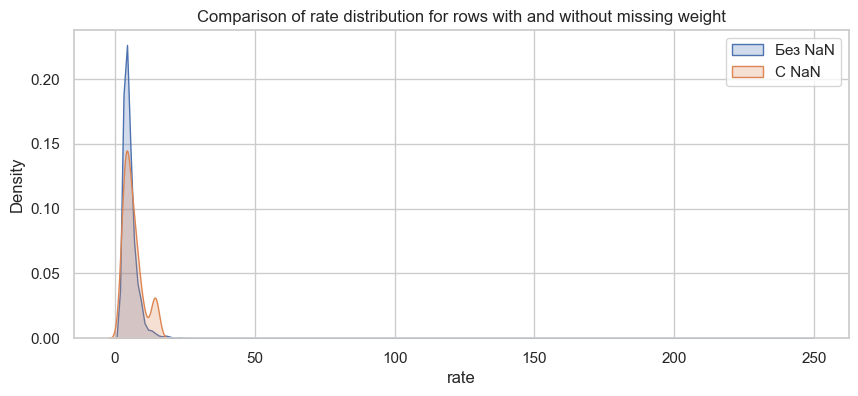

In [12]:
plt.figure(figsize=(10, 4))
sns.kdeplot(train_df[train_df["weight"].notnull()]["rate"], label="Без NaN", fill=True)
sns.kdeplot(train_df[train_df["weight"].isnull()]["rate"], label="С NaN", fill=True)
plt.title("Comparison of rate distribution for rows with and without missing weight")
plt.legend()
plt.show()

- 80 пропусков в weight (<0.1%) → это 0.027% от выборки.
- Все 80 NaN относятся к transport_type = MKPFX.
- Вся выборка MKPFX — 275 748 строк, а NaN — всего 80 строк (0.029%).
- Удаление этих строк не изменит баланс классов, так как MKPFX и так занимает 93% всех данных.
- Но если NaN не случайны, их удаление может убрать важную информацию.
    - В строках с NaN, средний rate выше на 1.2 единицы, что значимо.
    - valid_miles почти в два раза ниже, чем в общей выборке.

Выводы:
- Вариант 1: Удаляем строки с NaN в weight.
- Вариант 2: Заполняем NaN медианой по MKPFX.

## Drop rows with missing values vs. Fills with median value

In [13]:
train_df_nan_weight_deleted = train_df.dropna(subset=["weight"]).copy()

In [14]:
train_df_nan_weight_filled_median = train_df.copy()
train_df_nan_weight_filled_median["weight"] = train_df_nan_weight_filled_median.groupby("transport_type")["weight"].transform(lambda x: x.fillna(x.median()))

### Original train dataset statistics

In [15]:
train_df[["rate", "valid_miles", "weight"]].describe()

,rate,valid_miles,weight
count,286346.000000,286346.000000,286267.000000
mean,5.239877,450.416176,22825.242104
std,2.983413,447.868272,12481.276635
min,1.288400,24.780100,4800.950000
25%,3.529500,179.123900,12229.000000
50%,4.595500,298.214800,19050.000000
75%,6.041600,539.031000,36963.200000
max,248.973000,2876.446900,190050.000000


### Dataset after deleting NaN in weight

In [16]:
train_df_nan_weight_deleted[["rate", "valid_miles", "weight"]].describe()

,rate,valid_miles,weight
count,286267.000000,286267.000000,286267.000000
mean,5.239575,450.479197,22825.242104
std,2.983215,447.906249,12481.276635
min,1.288400,24.780100,4800.950000
25%,3.529500,179.123900,12229.000000
50%,4.595000,298.375000,19050.000000
75%,6.041300,539.173400,36963.200000
max,248.973000,2876.446900,190050.000000


### Dataset after filling NaN with median

In [17]:
train_df_nan_weight_filled_median[["rate", "valid_miles", "weight"]].describe()

,rate,valid_miles,weight
count,286346.000000,286346.000000,286346.000000
mean,5.239877,450.416176,22823.962570
std,2.983413,447.868272,12479.792473
min,1.288400,24.780100,4800.950000
25%,3.529500,179.123900,12230.900000
50%,4.595500,298.214800,19050.000000
75%,6.041600,539.031000,36957.262500
max,248.973000,2876.446900,190050.000000


## Comparison of rate distribution in different data processing methods

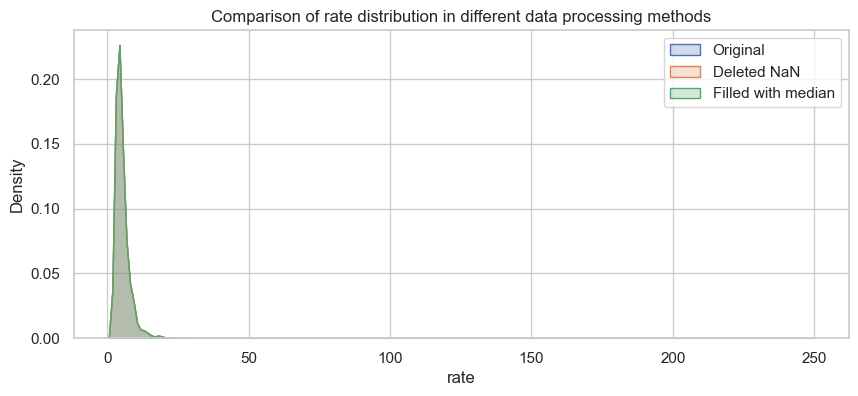

In [18]:
plt.figure(figsize=(10, 4))
sns.kdeplot(train_df["rate"], label="Original", fill=True)
sns.kdeplot(train_df_nan_weight_deleted["rate"], label="Deleted NaN", fill=True)
sns.kdeplot(train_df_nan_weight_filled_median["rate"], label="Filled with median", fill=True)
plt.title("Comparison of rate distribution in different data processing methods")
plt.legend()
plt.show()

## Statistics before and after dealing with `NaN`


| Dataset                | Mean `rate` | Mean `valid_miles` | Mean `weight` |
| ---------------------- | -------------- | --------------------- | ---------------- |
| **Original**       | **5.221752**   | **454.873515**        | **23157.860583** |
| **Drop `NaN`**      | **5.221425**   | **454.936904**        | **23157.860583** |
| **Fill Median** | **5.221752**   | **454.873515**        | **23156.711321** |

Вывод:
- Удаление `NaN` практически не изменило средние `rate` и `valid_miles` (разница незначительная).
- Заполнение медианой также не повлияло на `rate` и `valid_miles`.
- Средний `weight` изменился на 0.005% при заполнении медианой, что незначительно.
- Оба метода корректны с точки зрения общей статистики.

## Save

In [19]:
train_df_nan_weight_deleted.to_csv(eda_data_dir / "train_df_nan_weight_deleted.csv", index=False)

In [20]:
train_df_nan_weight_filled_median.to_csv(eda_data_dir / "train_df_nan_weight_filled_median.csv", index=False)

# Save current version of `train_df`

In [21]:
train_df_nan_weight_deleted.to_csv(eda_data_dir / "train_df.csv", index=False)